In [1]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np

import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.photUtils as photUtils

from mafContrib import StarGalaxyModel

In [4]:
opsdb = db.OpsimDatabase('../../enigma_1189_sqlite.db')
outDir = 'output_directory'
resultsDb = db.ResultsDb(outDir=outDir)

In [37]:
# Delete the metric from the registry if it already exists; we want to redefine it.
try:
    del metrics.BaseMetric.registry['__main__.StarGalaxySeparationMetric']
except KeyError:
    pass

class StarGalaxySeparationMetric(metrics.BaseMetric):
    """Calculate Star/Galaxy separation, in some quantification."""
    
    def __init__(self, target_mag=None, metricName='StarGalaxySeparation', **kwargs):
        """Instantiate some of the other metrics that we call."""
        
        assert target_mag is not None
        self.target_mag = target_mag
        self.sg_model = StarGalaxyModel()
        
        self.m5_metric = metrics.Coaddm5Metric(metricName="__coaddm5")
        col = ['finSeeing', 'fiveSigmaDepth']
        super(StarGalaxySeparationMetric, self).__init__(col=col, metricName=metricName,
                                                         units="mag",
                                                         **kwargs)
        

    def contamination_frac(self, alpha_psf, m5_depth, contam_limit=1.0):
        """This function runs StarGalaxyModel's differential contamination code,
        given values for the seeing and m5 depth. It returns the magnitude at which
        the differential contamination exceeds contam_limit.
        """
        i_mags = linspace(m5_depth - 3.0, m5_depth + 0.5, 20)
        contam = self.sg_model.make_differential_contamination(i_mags, 
                                                               m5=m5_depth, 
                                                               theta_obs=alpha_psf,
                                                               galactic_lat=45)
        limiting_mag = i_mags[np.argwhere(contam > contam_limit)][0]
        return limiting_mag
    
    def median_psf(self, dataSlice, slicePoint=None):
        return np.median(dataSlice['finSeeing'])        
        
    def run(self, dataSlice, slicePoint=None):
        
        coadd_m5_depth = self.m5_metric.run(dataSlice, slicePoint=slicePoint)
        alpha_psf = self.median_psf(dataSlice, slicePoint=slicePoint)
        
        contam = self.contamination_frac(alpha_psf, coadd_m5_depth)
        
        return contam

In [41]:
metric1 = StarGalaxySeparationMetric(target_mag=24.0)
metric2 = metrics.Coaddm5Metric()
#metric2 = metrics.MedianMetric("finSeeing")

slicer1 = slicers.HealpixSlicer(nside=64)
slicer1.plotFuncs = [plots.HealpixSkyMap, plots.HealpixHistogram]
sqlconstraint= 'filter = "i"'

# MetricBundle = combination of the metric, slicer, and sqlconstraint
snr_bundle = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)
m5_bundle = metricBundles.MetricBundle(metric2, slicer1, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [42]:
bundleDict = {'SNR_24':snr_bundle, 'M5': m5_bundle}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()


Querying database with constraint filter = "i"
Found 545488 visits
Running:  ['M5', 'SNR_24']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter = "i" sqlconstraint now.
Plotting complete.


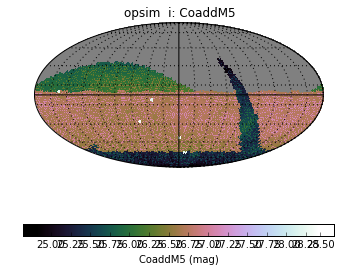

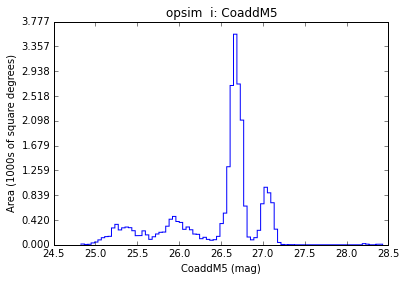

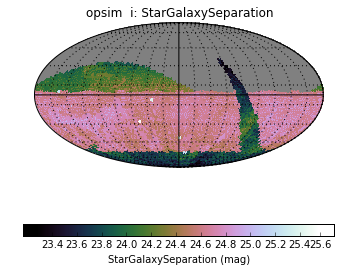

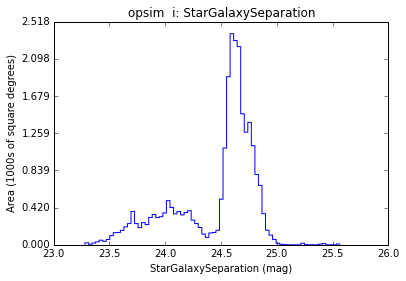

In [43]:
group.plotAll(closefigs=False, )